# 主要介绍了滤波器组和梅尔频率倒谱系数是怎么得到的，参考[博客](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

## 导入必要的工具包

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
wav_path= r"C:\Users\Administrator\Desktop\test.wav"

In [3]:
#读取wav和绘制时域图
#对于语音，只建议使用librosa库
import librosa
from librosa.display import waveplot
import matplotlib.pyplot as plt
%matplotlib inline

## 导入wav文件并绘制时域图

声音长度： 268985
采样率： 8000


Text(0.5, 1.0, 'Time Series wave')

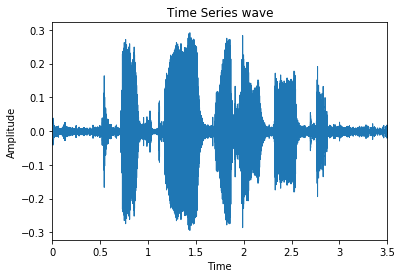

In [9]:
#导入
wave, sample_rate= librosa.load(wav_path,sr= None)
print("声音长度：",len(wave))
print("采样率：",sample_rate)
wave= wave[:int(3.5*sample_rate)]
#绘制时域图
waveplot(wave, sample_rate)
plt.ylabel("Amplitude")
plt.title("Time Series wave")

## 预加重

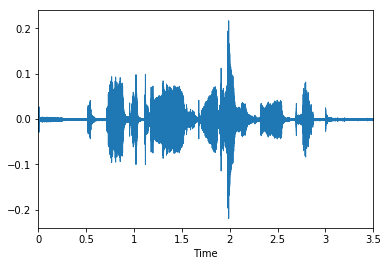

In [18]:
temp= np.append(wave[0],wave[1:]-0.97*wave[:-1])
waveplot(temp,sample_rate)

## 分帧加窗

In [20]:
#分帧
frame_size=0.025
frame_stride= 0.01
frame_length, frame_step= frame_size*sample_rate, frame_stride*sample_rate
signal_length= len(temp)
frame_length= int(round(frame_length))
frame_step= int(round(frame_step))
num_frames= int(np.ceil(float(np.abs(signal_length-frame_length))/frame_step))
pad_signal_length= num_frames*frame_step+frame_length
z= np.zeros([pad_signal_length-signal_length])
pad_signal= np.append(temp, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames= pad_signal[indices.astype(np.int32,copy=False)]

In [28]:
#加窗
frames*=np.hamming(frame_length)

In [34]:
#FFT
NFFT= 512
mag_frames= np.absolute(np.fft.rfft(frames,NFFT))
#功率
pow_frames= ((1.0/NFFT)*((mag_frames)**2))

功率的计算公式是这样的：
$$P = \frac{{{{\left| {FFT\left( {{x_i}} \right)} \right|}^2}}}{N}$$

In [36]:
nfilt=40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [41]:
num_cep=12
mfcc= dct(filter_banks,type=2, axis=1,norm= 'ortho')[:,1:(num_cep+1)]

In [42]:
mfcc.shape

(348, 12)